<a href="https://colab.research.google.com/github/sugiyama404/ReinfoceLearningForTrading/blob/main/simple_rl_random.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import random
from google.colab import drive
import copy

from datetime import datetime
from matplotlib import pyplot as plt

drive.mount('/content/drive/')
nov_dir = 'Colab Notebooks/dataset/reinforcement_learning/'
nov_path = '/content/drive/My Drive/' + nov_dir + 'sp500_test.csv'
exp_dir = 'Colab Notebooks/workspace/export/'
csv_path = '/content/drive/My Drive/' + exp_dir + 'simple_rl_random.csv'

df = pd.read_csv(nov_path)
df['Date'] = pd.to_datetime(df['Date'], format = '%Y-%m-%d')

Mounted at /content/drive/


In [2]:
class Environment:
    def __init__(self, df, initial_money=1000, mode = 'test'):

        self.df = df.dropna().reset_index()
        self.df_total_steps = len(self.df)-1
        self.initial_money = initial_money
        self.mode = mode
        self.trade_time = None
        self.trade_win = None
        self.brfore_buy_cash = None
        self.action_space = np.array([0, 1, 2])
        self.hold_a_position = None
        self.now_price = None
        self.cash_in_hand = None

        self.reset()
        
    def reset(self):

        self.trade_time = 0
        self.trade_win = 0
        self.brfore_buy_cash = 0
        self.end_step = self.df_total_steps
        self.now_step = 0
        self.hold_a_position = 0.0
        self.now_price = self.df.loc[self.now_step, 'SP500']
        self.cash_in_hand = self.initial_money

        return self._get_now_state()

    def step(self, action):

        self.now_step += 1
        self.now_price = self.df.loc[self.now_step, 'SP500']
 
        prev_revenue = self._get_revenue()

        done = (self.end_step == self.now_step)

        self._trade(action,done)
        cur_revenue = self._get_revenue()
        reward = cur_revenue - prev_revenue

        if self.mode == 'test':
            info = { 'cur_revenue' : cur_revenue , 'trade_time' : self.trade_time, 'trade_win' : self.trade_win }
        else:
            info = { 'cur_revenue' : cur_revenue }

        return self._get_now_state(), reward, done, info

    def _get_now_state(self):
        state = np.empty(3)
        state[0] = self.hold_a_position
        state[1] = self.now_price
        state[2] = self.cash_in_hand
        return state

    def _get_revenue(self):
        return self.hold_a_position * self.now_price + self.cash_in_hand

    def _trade(self, action,lastorder = False):
        if lastorder:
            self.cash_in_hand += self.now_price * self.hold_a_position
            self.hold_a_position = 0
        else:
            if self.action_space[0] == action: # sell
                if self.hold_a_position != 0:
                    self.cash_in_hand += self.now_price * self.hold_a_position
                    self.hold_a_position = 0
                    if self.mode == 'test':
                        self.trade_time += 1
                        if self.cash_in_hand > self.brfore_buy_cash:
                            self.trade_win += 1 
            if self.action_space[2] == action: # buy
                if self.hold_a_position == 0:
                    buy_flag = True
                    if self.mode == 'test':
                        self.brfore_buy_cash = copy.copy(self.cash_in_hand)
                    while buy_flag:
                        if self.cash_in_hand > self.now_price:
                            self.hold_a_position += 1
                            self.cash_in_hand -= self.now_price
                        else:
                            buy_flag = False

In [3]:
def play_game(env, episodes_times = 50, mode = 'test'):
    if mode == 'test':
        df_rec = pd.DataFrame(index=[], columns=['FixedProfit','TradeTimes','TradeWin'])
    else:
        df_rec = pd.DataFrame(index=[], columns=['FixedProfit'])

    for episode in range(episodes_times):
        state = env.reset()
        done = False
        start_time = datetime.now()
       
        while not done:
            action = np.random.randint(3, size=1)[0]
            state, reward, done, info = env.step(action)
           
        play_time = datetime.now() - start_time
        if mode == 'test':
            record = pd.Series([info['cur_revenue'],info['trade_time'],info['trade_win']], index=df_rec.columns)
            print(f"Episode: {episode + 1}/{episodes_times} RapTime: {play_time} FixedProfit: {info['cur_revenue']:.0f} TradeTimes: {info['trade_time']} TradeWin: {info['trade_win']}")
        else:
            record = pd.Series(info['cur_revenue'], index=df_rec.columns)
            print(f"Episode: {episode + 1}/{episodes_times} RapTime: {play_time} FixedProfit: {info['cur_revenue']:.0f}")
        df_rec = df_rec.append(record, ignore_index=True)
    return df_rec

Episode: 1/100 RapTime: 0:00:00.042010 FixedProfit: 1103312 TradeTimes: 140 TradeWin: 81
Episode: 2/100 RapTime: 0:00:00.047017 FixedProfit: 1148728 TradeTimes: 143 TradeWin: 94
Episode: 3/100 RapTime: 0:00:00.059005 FixedProfit: 1646851 TradeTimes: 144 TradeWin: 100
Episode: 4/100 RapTime: 0:00:00.065148 FixedProfit: 2056375 TradeTimes: 153 TradeWin: 99
Episode: 5/100 RapTime: 0:00:00.046999 FixedProfit: 922744 TradeTimes: 145 TradeWin: 79
Episode: 6/100 RapTime: 0:00:00.046491 FixedProfit: 1005858 TradeTimes: 126 TradeWin: 76
Episode: 7/100 RapTime: 0:00:00.047456 FixedProfit: 956759 TradeTimes: 156 TradeWin: 92
Episode: 8/100 RapTime: 0:00:00.048590 FixedProfit: 1252684 TradeTimes: 144 TradeWin: 88
Episode: 9/100 RapTime: 0:00:00.047374 FixedProfit: 869898 TradeTimes: 143 TradeWin: 80
Episode: 10/100 RapTime: 0:00:00.052244 FixedProfit: 1118453 TradeTimes: 138 TradeWin: 84
Episode: 11/100 RapTime: 0:00:00.063356 FixedProfit: 1702038 TradeTimes: 152 TradeWin: 94
Episode: 12/100 RapTi

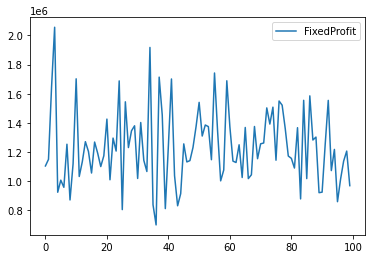

In [4]:
initial_money=1000000
episodes_times = 100
mode = 'test'
env = Environment(df, initial_money=initial_money,mode = mode)
df_rec = play_game(env, episodes_times = episodes_times, mode = mode)
print(df_rec.describe())
if mode == 'test':
    df_rec = df_rec.drop(['TradeTimes','TradeWin'], axis=1)
df_rec.to_csv(csv_path)
df_rec.plot()
plt.show()